In [1]:
import pandas as pd
import numpy as np
import pickle, gc
from matplotlib import pyplot as plt

K折交叉验证会把样本数据随机的分成K份（一般是均分），每次随机的选择K-1份作为训练集，剩下的1份做测试集。

对非平衡数据可以用分层采样StratifiedKFold，就是在每一份子集中都保持和原始数据集相同的类别比例

In [2]:
train_labels = pd.read_csv('./data/train_labels.csv')
train_labels.head(2)

,customer_ID,target
0,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,0
1,00000fd6641609c6ece5454664794f0340ad84dddce9a2...,0


In [3]:
train_labels.isna().any().any(), train_labels.customer_ID.duplicated().any()

(False, False)

In [4]:
label_stats = pd.DataFrame({'absolute': train_labels.target.value_counts(), 'relative': train_labels.target.value_counts() / len(train_labels)})
label_stats['absolute upsampled'] = label_stats.absolute * np.array([20, 1])
label_stats['relative upsampled'] = label_stats['absolute upsampled'] / label_stats['absolute upsampled'].sum()
label_stats

,absolute,relative,absolute upsampled,relative upsampled
0,340085,0.741066,6801700,0.98283
1,118828,0.258934,118828,0.01717


In [5]:
%%time

train = pd.read_feather('./data/train_data.ftr')
test = pd.read_feather('./data/test_data.ftr')
with pd.option_context('display.min_rows', 6):
    display(train)
    display(test)

,customer_ID,S_2,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,...,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145,target
0,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-03-09,0.938477,0.001734,0.008728,1.006836,0.009224,0.124023,0.008774,0.004707,...,NaN,NaN,0.002426,0.003706,0.003819,NaN,0.000569,0.000610,0.002674,0
1,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-04-07,0.936523,0.005775,0.004925,1.000977,0.006153,0.126709,0.000798,0.002714,...,NaN,NaN,0.003956,0.003166,0.005032,NaN,0.009575,0.005493,0.009216,0
2,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-05-28,0.954102,0.091492,0.021652,1.009766,0.006817,0.123962,0.007599,0.009422,...,NaN,NaN,0.003269,0.007328,0.000427,NaN,0.003429,0.006985,0.002604,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5531448,fffff1d38b785cef84adeace64f8f83db3a0c31e8d92ea...,2018-01-06,0.982910,0.444092,0.013153,0.815430,0.003456,0.100525,0.002111,0.012344,...,NaN,NaN,0.009956,0.009995,0.001088,NaN,0.005692,0.006775,0.005566,0
5531449,fffff1d38b785cef84adeace64f8f83db3a0c31e8d92ea...,2018-02-06,0.969727,0.442627,0.009857,1.003906,0.005116,0.101807,0.009933,0.008575,...,NaN,NaN,0.005543,0.006565,0.009880,NaN,0.008125,0.001168,0.003983,0
5531450,fffff1d38b785cef84adeace64f8f83db3a0c31e8d92ea...,2018-03-14,0.981934,0.002474,0.000077,0.992676,0.000809,0.119141,0.003286,0.014091,...,NaN,NaN,0.007317,0.002888,0.006207,NaN,0.005112,0.003183,0.001914,0


,customer_ID,S_2,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,...,D_136,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145
0,00000469ba478561f23a92a868bd366de6f6527a684c9a...,2019-02-19,0.631348,0.001912,0.010727,0.814453,0.007545,0.168701,0.009972,0.002348,...,NaN,NaN,NaN,NaN,0.004669,NaN,NaN,NaN,0.008278,NaN
1,00000469ba478561f23a92a868bd366de6f6527a684c9a...,2019-03-25,0.586914,0.005276,0.011024,0.811035,0.001817,0.241333,0.000166,0.009132,...,NaN,NaN,NaN,0.000142,0.004940,0.009018,NaN,0.003695,0.003754,0.001460
2,00000469ba478561f23a92a868bd366de6f6527a684c9a...,2019-04-25,0.608887,0.003326,0.016388,1.004883,0.000114,0.267090,0.004196,0.004192,...,NaN,NaN,NaN,0.000074,0.002113,0.004658,NaN,0.003155,0.002155,0.006481
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11363759,fffffa7cf7e453e1acc6a1426475d5cb9400859f82ff61...,2019-02-17,0.459961,0.005245,0.004421,0.818848,0.000665,NaN,0.000559,0.007057,...,NaN,NaN,NaN,0.007797,0.007740,0.008194,NaN,0.009384,0.003593,0.005604
11363760,fffffa7cf7e453e1acc6a1426475d5cb9400859f82ff61...,2019-03-19,0.460449,0.002663,0.009529,0.816406,0.009026,NaN,0.008530,0.006851,...,NaN,NaN,NaN,0.007195,0.008453,0.004776,NaN,0.006199,0.005604,0.005970
11363761,fffffa7cf7e453e1acc6a1426475d5cb9400859f82ff61...,2019-04-18,0.454590,0.004402,0.000346,0.810059,0.008736,NaN,0.000937,0.003494,...,NaN,NaN,NaN,0.003399,0.009590,0.006187,NaN,0.007675,0.006443,0.003143


CPU times: total: 29.5 s
Wall time: 32.2 s


In [6]:
# S_2 是statement data，通知日期
print(f'Train statement dates: {train.S_2.min()}, {train.S_2.max()}, {train.S_2.isna().any()}')
print(f'Test statement dates: {train.S_2.min()}, {train.S_2.max()}, {train.S_2.isna().any()}')

Train statement dates: 2017-03-01 00:00:00, 2018-03-31 00:00:00, False
Test statement dates: 2017-03-01 00:00:00, 2018-03-31 00:00:00, False


In [7]:
print(f'Train data memory usage: {train.memory_usage().sum() / 1e9} GBytes')
print(f'Test data memory usage:  {test.memory_usage().sum() / 1e9} GBytes')

Train data memory usage: 2.151736827 GBytes
Test data memory usage:  4.329595558 GBytes


In [8]:
train.info(max_cols=200, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5531451 entries, 0 to 5531450
Data columns (total 191 columns):
 #    Column       Non-Null Count    Dtype         
---   ------       --------------    -----         
 0    customer_ID  5531451 non-null  object        
 1    S_2          5531451 non-null  datetime64[ns]
 2    P_2          5485466 non-null  float16       
 3    D_39         5531451 non-null  float16       
 4    B_1          5531451 non-null  float16       
 5    B_2          5529435 non-null  float16       
 6    R_1          5531451 non-null  float16       
 7    S_3          4510907 non-null  float16       
 8    D_41         5529435 non-null  float16       
 9    B_3          5529435 non-null  float16       
 10   D_42         791314 non-null   float16       
 11   D_43         3873055 non-null  float16       
 12   D_44         5257132 non-null  float16       
 13   B_4          5531451 non-null  float16       
 14   D_45         5529434 non-null  float16       
 1

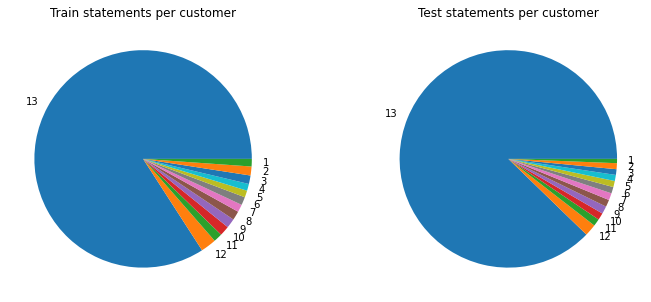

In [9]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
train_sc = train.customer_ID.value_counts().value_counts().sort_index(ascending=False).rename('Train statements per customer')
ax1.pie(train_sc, labels=train_sc.index)
ax1.set_title(train_sc.name)
test_sc = test.customer_ID.value_counts().value_counts().sort_index(ascending=False).rename('Test statements per customer')
ax2.pie(test_sc, labels=test_sc.index)
ax2.set_title(test_sc.name)
plt.show()

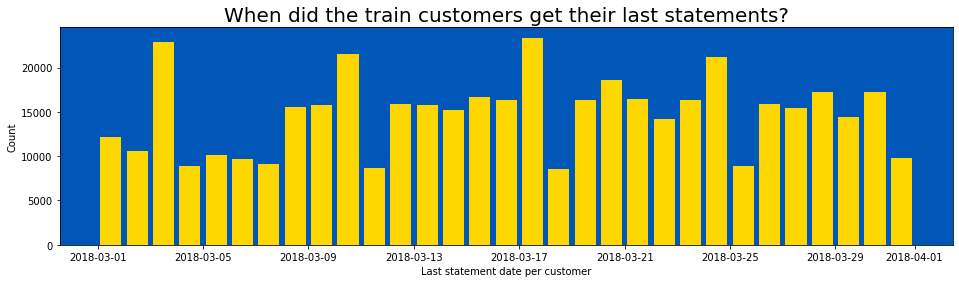

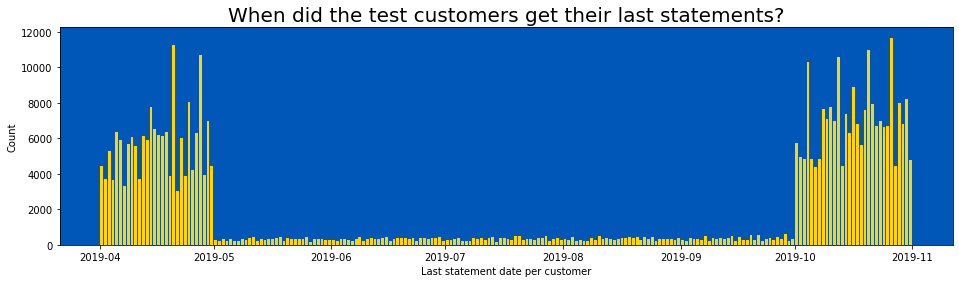

In [10]:
temp = train.S_2.groupby(train.customer_ID).max()
plt.figure(figsize=(16, 4))
plt.hist(temp, bins=pd.date_range('2018-03-01', '2018-04-01', freq='d'), rwidth=0.8, color='#ffd700')
plt.title('When did the train customers get their last statements?', fontsize=20)
plt.xlabel('Last statement date per customer')
plt.ylabel('Count')
plt.gca().set_facecolor('#0057b8')
plt.show()
del temp

temp = test.S_2.groupby(train.customer_ID).max()
plt.figure(figsize=(16, 4))
plt.hist(temp, bins=pd.date_range('2019-04-01', '2019-11-01', freq='d'), rwidth=0.74, color='#ffd700')
plt.title('When did the test customers get their last statements?', fontsize=20)
plt.xlabel('Last statement date per customer')
plt.ylabel('Count')
plt.gca().set_facecolor('#0057b8')
plt.show()
del temp

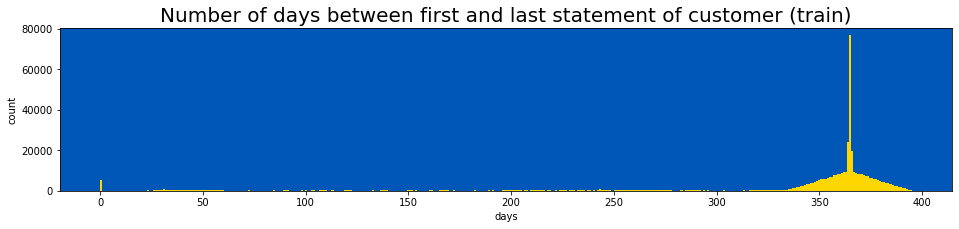

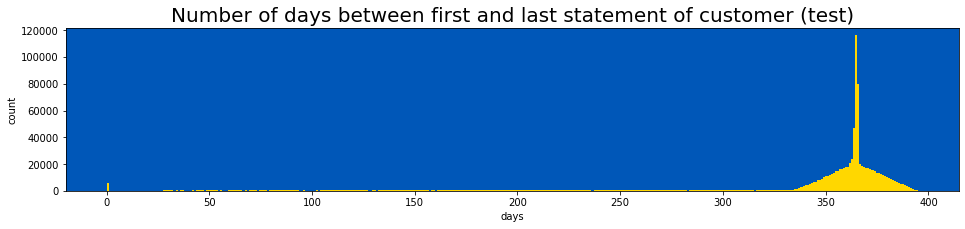

In [11]:
temp = train.S_2.groupby(train.customer_ID).agg(['max', 'min'])
plt.figure(figsize=(16, 3))
plt.hist((temp['max'] - temp['min']).dt.days, bins=400, color='#ffd700')
plt.xlabel('days')
plt.ylabel('count')
plt.title('Number of days between first and last statement of customer (train)', fontsize=20)
plt.gca().set_facecolor('#0057b8')
plt.show()

temp = test.S_2.groupby(test.customer_ID).agg(['max', 'min'])
plt.figure(figsize=(16, 3))
plt.hist((temp['max'] - temp['min']).dt.days, bins=400, color='#ffd700')
plt.xlabel('days')
plt.ylabel('count')
plt.title('Number of days between first and last statement of customer (test)', fontsize=20)
plt.gca().set_facecolor('#0057b8')
plt.show()
del temp

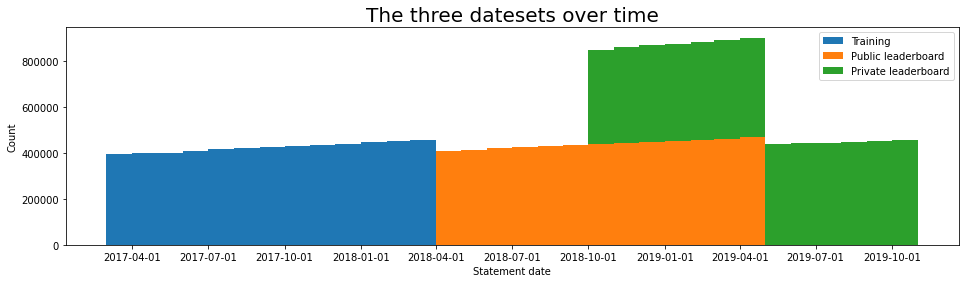

In [12]:
temp = pd.concat([train[['customer_ID', 'S_2']], test[['customer_ID', 'S_2']]], axis=0)
temp.set_index('customer_ID', inplace=True)
temp['last_month'] = temp.groupby('customer_ID').S_2.max().dt.month
last_month = temp['last_month'].values

plt.figure(figsize=(16, 4))
plt.hist([temp.S_2[temp.last_month == 3],
          temp.S_2[temp.last_month == 4],
          temp.S_2[temp.last_month == 10]],
         bins = pd.date_range('2017-03-01', '2019-11-01', freq='MS'),
         label = ['Training', 'Public leaderboard', 'Private leaderboard'],
         stacked = True
        )
plt.xticks(pd.date_range('2017-03-01', '2019-11-01', freq='QS'))
plt.xlabel('Statement date')
plt.ylabel('Count')
plt.title('The three datesets over time', fontsize = 20)
plt.legend()
plt.show()

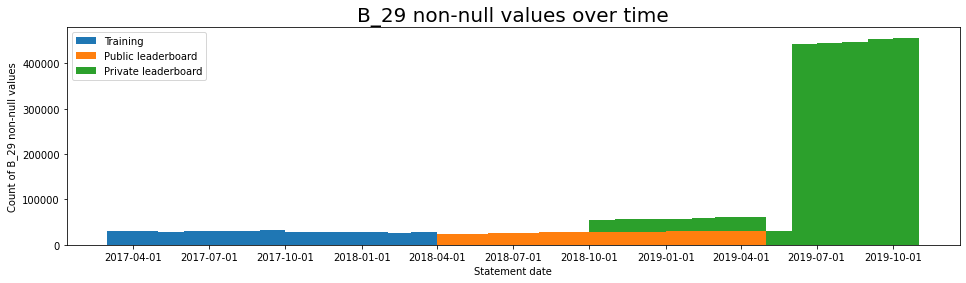

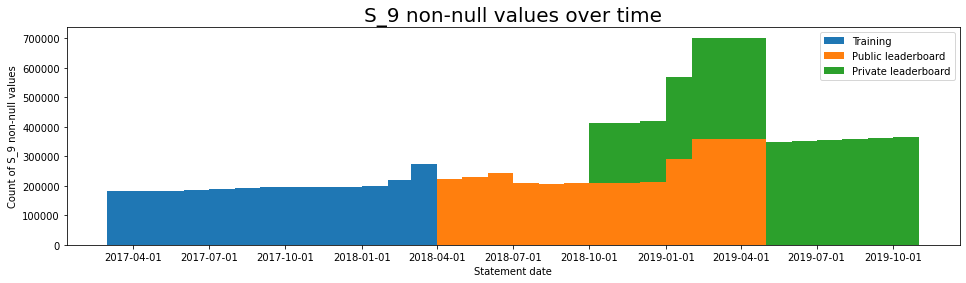

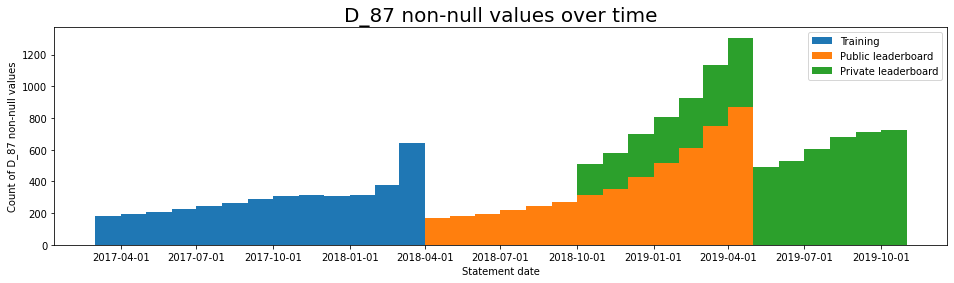

In [14]:
for f in ['B_29', 'S_9', 'D_87']:
    temp = pd.concat([train[[f, 'S_2']], test[[f, 'S_2']]], axis=0)
    temp['last_month'] = last_month
    temp['has_f'] = ~temp[f].isna()
    
    plt.figure(figsize=(16, 4))
    plt.hist([temp.S_2[temp.has_f & (temp.last_month == 3)],
              temp.S_2[temp.has_f & (temp.last_month == 4)],
              temp.S_2[temp.has_f & (temp.last_month == 10)]],
             bins=pd.date_range('2017-03-01', '2019-11-01', freq='MS'),
             label=['Training', 'Public leaderboard', 'Private leaderboard'],
             stacked=True)
    plt.xticks(pd.date_range('2017-03-01', '2019-11-01', freq='QS'))
    plt.xlabel('Statement date')
    plt.ylabel(f'Count of {f} non-null values')
    plt.title(f'{f} non-null values over time', fontsize=20)
    plt.legend()
    plt.show()

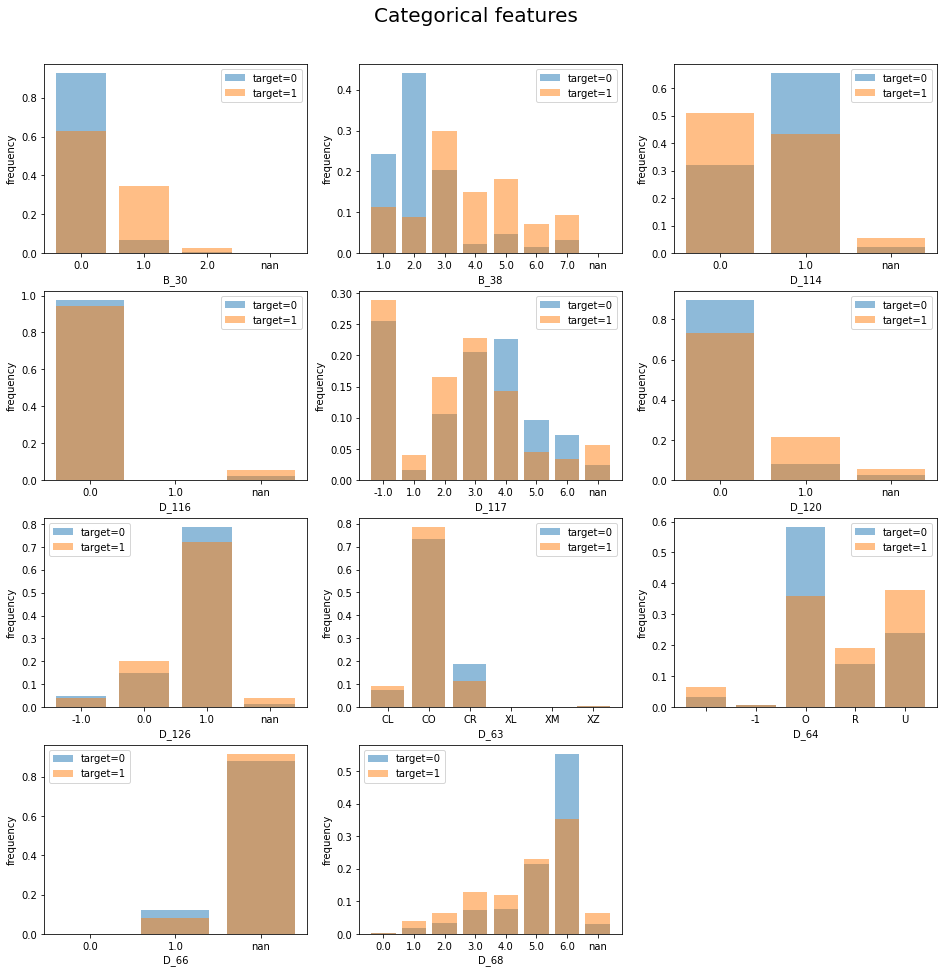

In [17]:
cat_features =  ['B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126', 'D_63', 'D_64', 'D_66', 'D_68']
plt.figure(figsize=(16, 16))
for i, f in enumerate(cat_features):
    plt.subplot(4, 3, i+1)
    temp = pd.DataFrame(train[f][train.target == 0].value_counts(dropna=False, normalize=True).sort_index().rename('count'))
    temp.index.name = 'value'
    temp.reset_index(inplace=True)
    plt.bar(temp.index, temp['count'], alpha=0.5, label='target=0')
    temp = pd.DataFrame(train[f][train.target == 1].value_counts(dropna=False, normalize=True).sort_index().rename('count'))
    temp.index.name = 'value'
    temp.reset_index(inplace=True)
    plt.bar(temp.index, temp['count'], alpha=0.5, label='target=1')
    plt.xlabel(f)
    plt.ylabel('frequency')
    plt.legend()
    plt.xticks(temp.index, temp.value)
plt.suptitle('Categorical features', fontsize=20, y=0.93)
plt.show()
del temp